# Human Segmentaion-portrait

### 핸드폰의  '인물사진 모드(portrait mode)'  촬영 방법

- 듀얼 카메라를 이용해 DSLR의 아웃포커싱 기능
- 화각이 다른 두 렌즈를 사용
   - 일반(광각) 렌즈 : 배경을 촬영
   - 망원 렌즈 :인물을 촬영 -> 뒷배경을 흐리게 처리한 후 망원 렌즈의 인물과 적절하게 합성
- 인물사진 모드에서 사용되는 용어
   - 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus)
   - '인물사진(portrait)'
<br> 

### DSLR 사진 촬영 방법
- 피사계 심도(depth of field, DOF)를 얕게 하여 초점이 맞은 피사체를 제외한 배경을 흐리게 만들기


### 학습목표

- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.
<br><br>

### 준비물

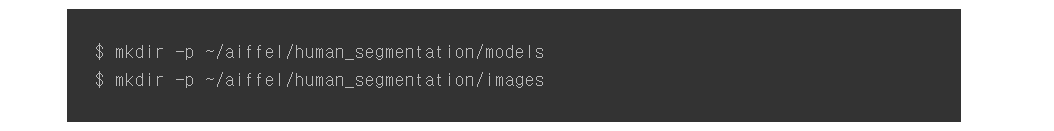


## 셸로우 포커스 만들기

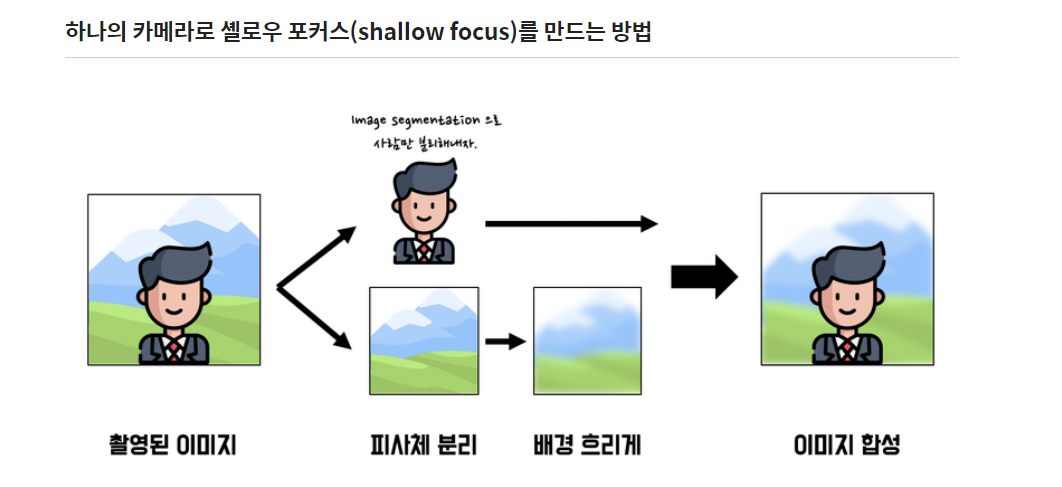

- 렌즈 한 개로 두 개의 렌즈가 맡은 역할을 구현


#### 진행 순서
- 배경이 있는 셀카를 촬영, 이미지 준비
- 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리
- 블러링(blurring) 기술로 배경을 흐리게 만들ㄹ기
- 피사체를 배경의 원래 위치에 합성


## 루브릭1
### 1-1 인물사진

### 💥 필요한 라이브러리 가져오기
- urllib는 웹에서 데이터를 다운로드할 때 사용
- cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요
- pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
   - 시맨틱 세그멘테이션 모델을 직접 만들기에는 어려우니 이번에는 준비된 모델을 사용


In [1]:
import os
import urllib     
import cv2       
import numpy as np

import pixellib
from pixellib.tune_bg import alter_bg
from pixellib.semantic import semantic_segmentation

from matplotlib import pyplot as plt

### 💥 이미지 가져와서 보기

(1280, 960, 3)


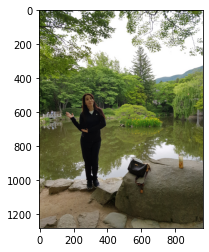

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 💥 세그멘테이션으로 사람 분리하기

#### 이미지 세그멘테이션(image segmentation)
- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
- 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정
- 공통 특징은 물리적 의미가 없을 수도 있고 있을 수도 있기 때문에 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출


#### 시맨틱 세그멘테이션(semantic segmentation)
- 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션
- 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법

🎉 **인스턴스의 id 뿐만이 아닌 클래스 라벨이 존재해야 시맨틱 세그멘테이션으로 학습이 가능**

#### 인스턴스 세그멘테이션(Instance segmentation)이란?
- '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법
- 사람 개개인별로 다른 라벨을 가지게 하여 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표
 

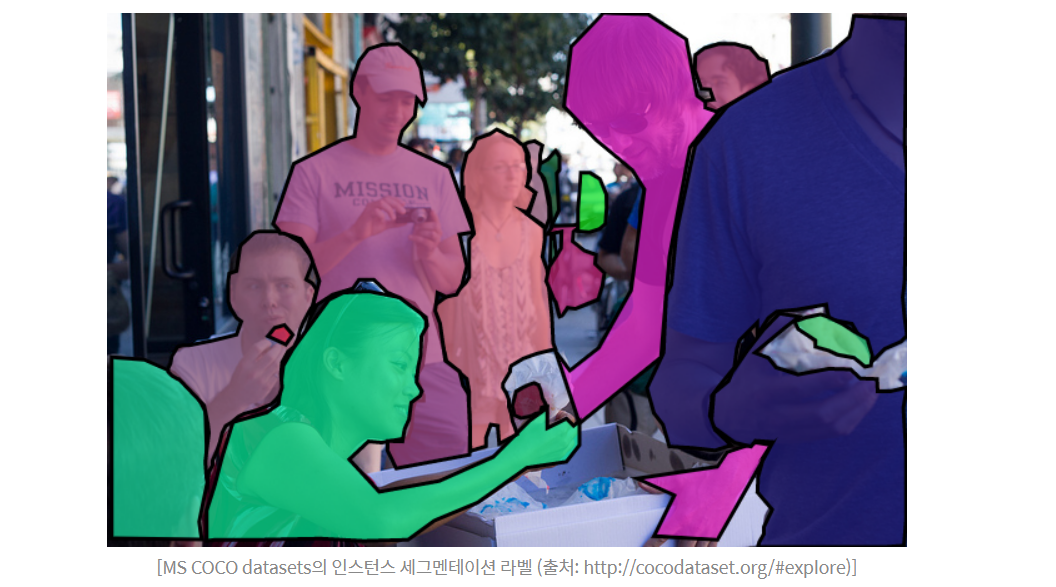

#### 워터쉐드 세그멘테이션(watershed segmentation)
- 0~255의 값을 그레이스케일(grayscale)로 변환해서 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분
- 낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점을 경계선으로 만들면 물체를 서로 구분 가능

###  시맨틱 세그멘테이션 다뤄보기
- DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용

#### [DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)

#### DeepLab 모델을 준비
- [PixelLib](https://github.com/ayoolaolafenwa/PixelLib)

> **PixelLib 설치**  
> pip3 install pixellib



## 💥세그멘테이션으로 사람 분리하기
#### PixelLib에서 제공해 주는 모델을 다운로드, 불러오기 <- 박성돈님이 가르쳐 주셔서 코드 줄임..ㅎㅎ

In [3]:
# 경로지정해서 모듈 읽어오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

#### 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델 생성, 로드

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#### segmentAsPascalvoc함수 : PASCAL VOC 데이터로 **학습된 모델을 이용**한다는 의미
#### 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요
#### [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

<br>

#### 모델로 학습 후 변수 지정

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

#### PASCAL VOC 데이터의 라벨 종류 확인

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

for index, name in enumerate(LABEL_NAMES):
    print(index, name )

0 background
1 aeroplane
2 bicycle
3 bird
4 boat
5 bottle
6 bus
7 car
8 cat
9 chair
10 cow
11 diningtable
12 dog
13 horse
14 motorbike
15 person
16 pottedplant
17 sheep
18 sofa
19 train
20 tv


### 모델에서 나온 출력값 살펴보기
- output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 저장
- segvalues : class_ids, masks 존재
   - class_ids를 통해 어떤 물체가 담겨 있는 지 확인 가능

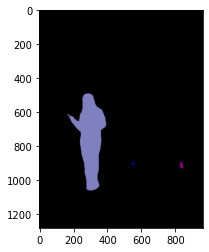

In [7]:
# 모델에서 나온 출력값 보기
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  5,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
chair
person


#### PixelLib에서 사용하는 색상 코드 가져오기

In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

#### 다른 물체의 색상을 알고 싶다면 -> colormap[class_id]로 검색


In [11]:
# 사람을 나타내는 15번째 색상 알아보기
colormap[15]

array([192, 128, 128])

#### output 이미지가 BGR 순서로 채널 배치, colormap은 RGB 순서로 채널 배치
####  추출해야 하는 색상 값의 순서 바꿔주기 필수!!

In [12]:
seg_color = (128,128,192)

#### seg_color로만 이루어진 seg_map 마스크를 만들기

In [13]:
print(type(output))
print(output.shape)

<class 'numpy.ndarray'>
(1280, 960, 3)


(1280, 960)


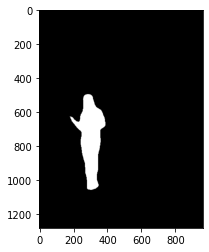

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

### 컬러마스크 만들기
- Bool 값에 255를 곱해서 숫자(0, 255)로 만들기
- 숫자로 만든 마스크에 적당한 수를 곱해서 컬러마스크 만들기

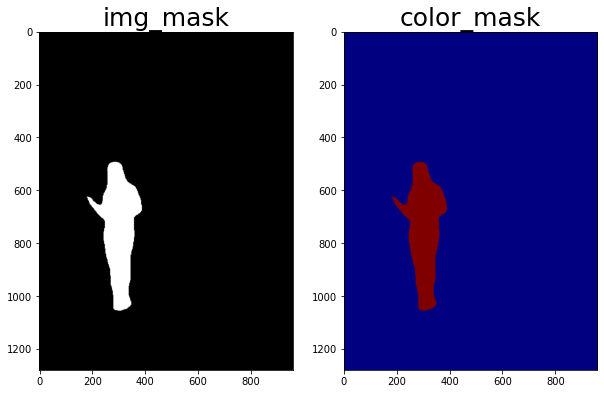

In [15]:
# True과 False인 값을 숫자로 바꾸기(0,255)
img_mask = seg_map.astype(np.uint8) * 255

# img_mask를 255와 0을 적당한 색상으로 바꾼 color_mask로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)


fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
axs[0].set_title("img_mask", fontsize=25)
axs[1].imshow(cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB))
axs[1].set_title("color_mask", fontsize=25)
plt.show()

#### 원래 이미지와 컬러 마스크 겹쳐 보기

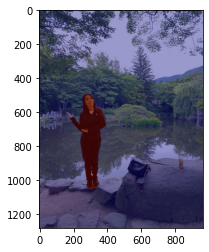

In [16]:
# 원래 이미지와 겹치기 -> 왜 겹치지??
# 이건 여기만 사용됨
img_show = img_orig.copy() 

# 원본 이미지와 컬러마스크를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기
####  blur() 함수를 이용해서 배경흐리게 하기

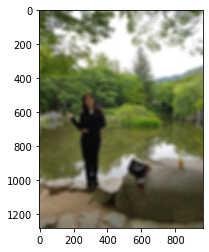

In [17]:
# (25,25)은 blurring kernel size
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### bitwise_not 함수를 이용하면 이미지가 반전(마스크는 2가지 밖에 존재하지 않는다)
- 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 된다.  


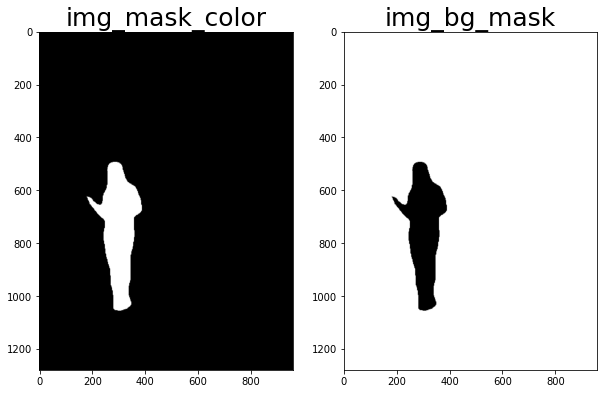

In [18]:
# img_mask를 컬러색상으로 바꾸고 변수지정
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 바꾼 컬러마스크를 색상 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(img_mask_color, cv2.COLOR_BGR2RGB))
axs[0].set_title("img_mask_color", fontsize=25)
axs[1].imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB))
axs[1].set_title("img_bg_mask", fontsize=25)
plt.show()

#### 반전된 세그멘테이션 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 획득
- 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
- 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 되어 결국 사람이 사라지게 되어 **블러된 배경만 획득**

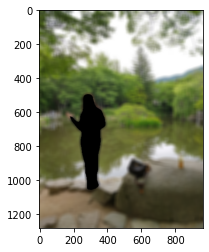

In [19]:
# img_bg_mask = cv2.bitwise_not(img_mask_color)
# 블러된 이미지, 컬러반전마스크를 합성해서 배경만 추출
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

#### [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)
- np.where(조건, 참일때, 거짓일때)
- 원하는 인덱스만 추출

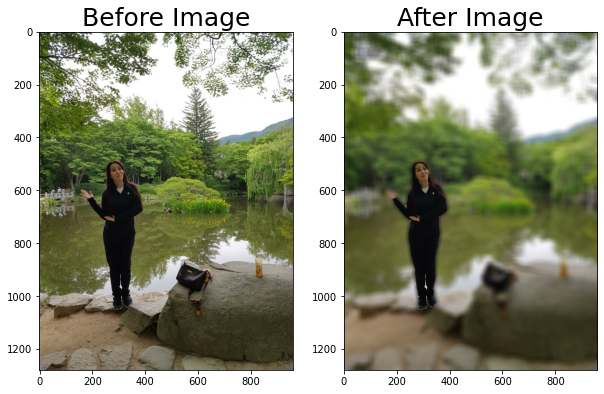

In [20]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
axs[0].set_title("Before Image", fontsize=25)
axs[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
axs[1].set_title("After Image", fontsize=25)

plt.show()

### 1-2 고양이

(676, 748, 3)


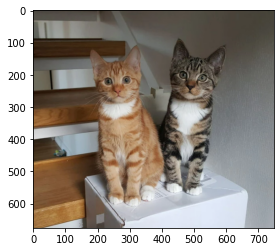

In [21]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
# 모듈 경로지정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 모델 만들기
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 학습 후 출력값 받기
segvalues, output = model.segmentAsPascalvoc(img_path)

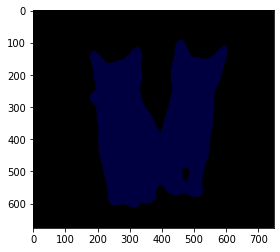

In [23]:
# 모델에서 나온 출력값 보기
plt.imshow(output)
plt.show()

In [24]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [25]:
# 고양이 색상 알아보기
colormap[8]

array([64,  0,  0])

In [26]:
seg_color = (0,  0,  64)

(676, 748)


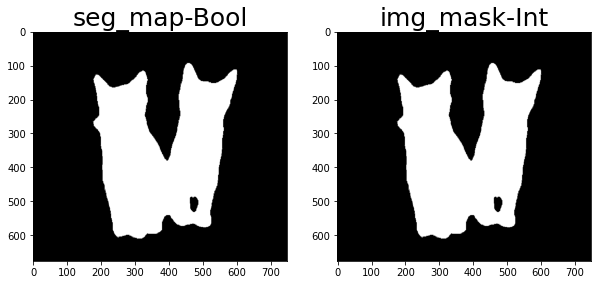

In [27]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

# True과 False인 값을 숫자로 바꾸기(0,255)
img_mask = seg_map.astype(np.uint8) * 255

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(seg_map, cmap='gray')
axs[0].set_title("seg_map-Bool", fontsize=25)

axs[1].imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
axs[1].set_title("img_mask-Int", fontsize=25)

plt.show()

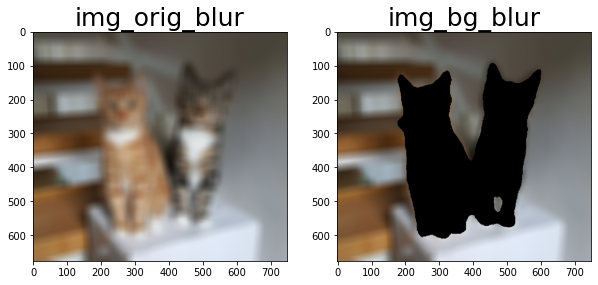

In [28]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (30,30))

# img_mask를 컬러색상으로 바꾸고 변수지정
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 바꾼 컬러마스크를 색상 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 블러된 이미지, 컬러반전마스크를 합성해서 배경만 추출
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)



fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
axs[0].set_title("img_orig_blur", fontsize=25)

axs[1].imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
axs[1].set_title("img_bg_blur", fontsize=25)

plt.show()

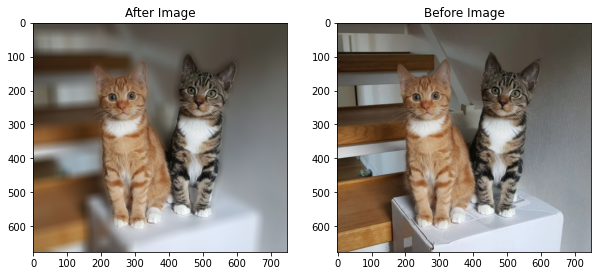

In [29]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
axs[0].set_title("After Image")
axs[1].set_title("Before Image")
plt.show()

### 1-3 배경전환 크로마키사진

#### [change_image_bg](https://github.com/ayoolaolafenwa/PixelLib/blob/master/Tutorials/change_image_bg.md)

#### PixelLib에서 박성돈님이 찾아 주셔서 그대로 차용

#### 이미지 가져오기

In [30]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/kong2.png'  
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/winter.png'  
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/'  

#### 모듈 가져오기

In [31]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'xception_pascalvoc.pb')

In [32]:
change_bg = alter_bg(model_type = "pb")
change_bg.load_pascalvoc_model("xception_pascalvoc.pb")
img_show = change_bg.change_bg_img(f_image_path = img_path, b_image_path = img_path2, output_image_name=img_path3 + "kong_winter.png")

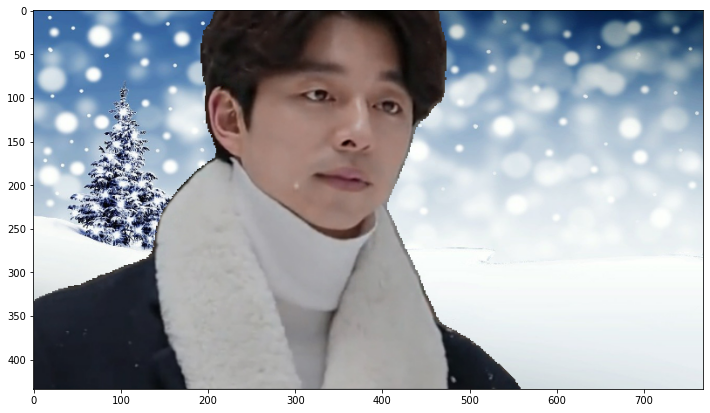

In [33]:
plt.figure(figsize=(12,10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 2.인물 사진에서 문제점 지적한 사진 제출
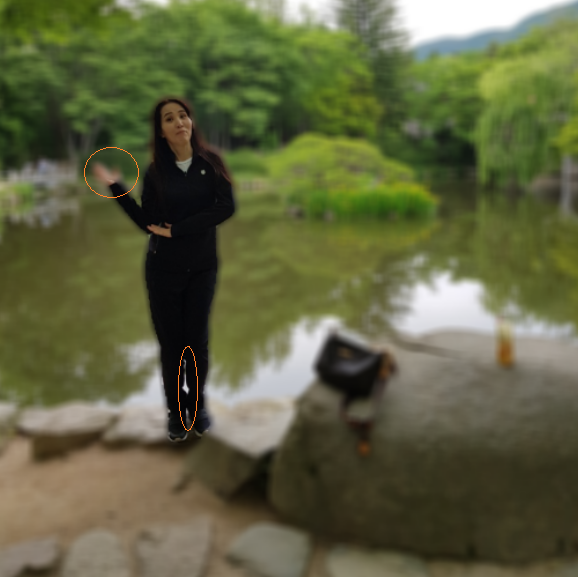

## 3. 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시



(1290, 860, 3)


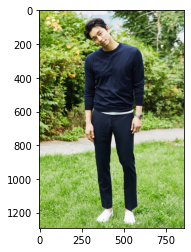

In [34]:
# 이미지 가져와서 보기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/kongyou.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### PixelLib에서 제공해 주는 모델을 다운로드, 모델 생성

In [35]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

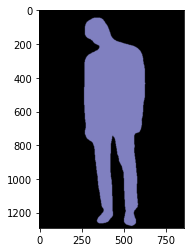

In [36]:
# 모델 훈련
segvalues, output = model.segmentAsPascalvoc(img_path)
# 모델에서 나온 출력값 보기
plt.imshow(output)
plt.show()

(1290, 860)


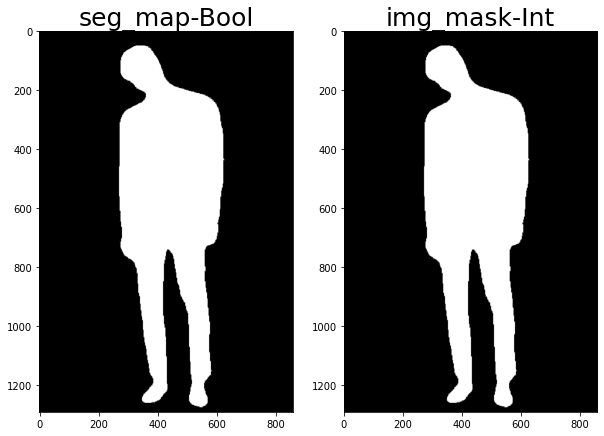

In [37]:
seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

# True과 False인 값을 숫자로 바꾸기(0,255)
img_mask = seg_map.astype(np.uint8) * 255

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(seg_map, cmap='gray')
axs[0].set_title("seg_map-Bool", fontsize=25)

axs[1].imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
axs[1].set_title("img_mask-Int", fontsize=25)

plt.show()

#### 블러된 배경만 추출

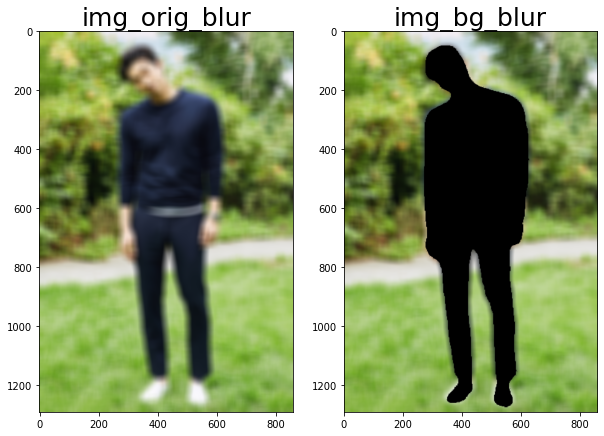

In [38]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (30,30))

# img_mask를 컬러색상으로 바꾸고 변수지정
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 바꾼 컬러마스크를 색상 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 블러된 이미지, 컬러반전마스크를 합성해서 배경만 추출
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)



fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
axs[0].set_title("img_orig_blur", fontsize=25)

axs[1].imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
axs[1].set_title("img_bg_blur", fontsize=25)

plt.show()

### 이미지합성

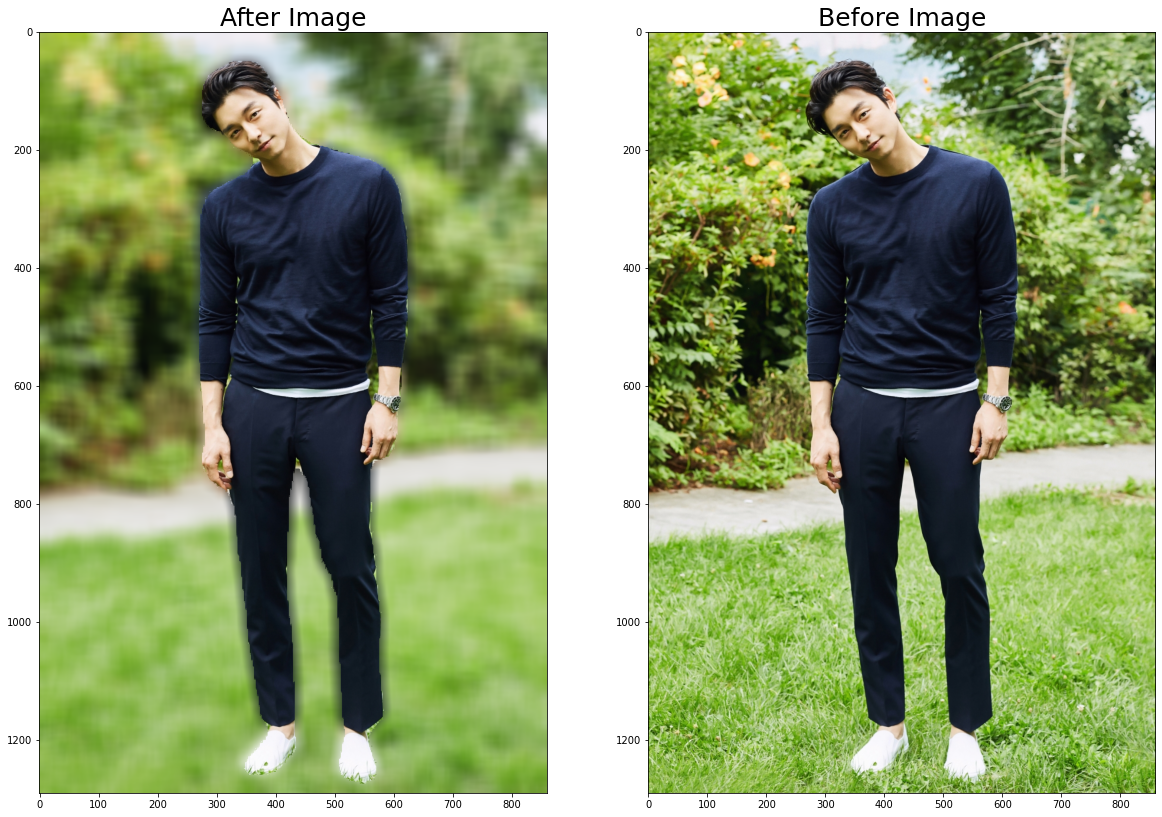

In [39]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig, axs = plt.subplots(1, 2, figsize=(20, 30))
axs[0].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
axs[0].set_title("After Image", fontsize=25)
axs[1].set_title("Before Image", fontsize=25)
plt.show()

#### 기존의 Sementic Segmention은 객체 추출은 잘 하나 세심함이 부족했다
#### 그래서 PixelLib에서 김민주님이 Instance Sementic을 하신다고 해서 찾다가 보니 PixelLib의 README를 읽어보니 PointRend가 더 세심하다고 도전했다.  
### 😱 [Detectron2/PointRend](https://github.com/facebookresearch/detectron2/tree/main/projects/PointRend)

#### Detectron2의 PointRend는 facebook에서 pytorch를 써야 이용가능했다.
#### 서버에서 pytorch를 설치할 수 없어서 노트북에 가상환경을 만들어서 pytorch를 설치했다.
#### pytorch 설치 후 pointRend를 github에 있는 대로 했더니 객체 이미지만 출력이 되고 sementic segmentaion처럼 마스크를 주지 않았다.. 
#### 아~~ 마스크를 어떻게 출력하지??? 구글링을 하다보니 detectron으로 가능할 것 같아서 detectron에 도전했다..
#### 그래.. detectron을 하는 YouTube를 보면 가능하지 않을까??
#### 동영상을 찾아서 시키는 대로 따라 했다. 근데 모듈을 읽어들이지 못한다.
#### 알고보니 detectron은 window를 싫어하는 것 처럼 윈도우랑 환경이 잘 안 맞다..
#### 구글링을 해서 가상환경을 만들고 지우기 여러번... 그러나 실패...
#### 또 구글링을 해보니 anaconda 4.8에 cuda를 기본적으로 탑재해서 detectron이 가능하다고 한다..
#### 이제는 anaconda를 지우고 옛날 버전부터 계속 설치, 지욱기, 설치, 지우기... 아~~ 눈알이 아프다..
#### 지금 현존에서는 anaconda 4.8버전을 구할 수가 없다.. 또 실패...
#### 내 노트북이 안되면 코랩에 도전해 보자.. 또 구글링.. YouTube.... 
#### 봐도 모르겠다.... 구글링 하다가 PointRend에서 객체색을 줘서 출력을 한 사진이 기억나서 이미지 검색...
#### 오예~~ 드디어 찾았다...    
## 🎉[마스크 얻은 경로, 파일](https://colab.research.google.com/drive/1GkWYlQnlDVLfZFyW5BmIDGQAtdNW_QCF#scrollTo=A8qpUiCnftD7)
#### 원하는 마스크를 출력하게 되었다.... 이미지로 출력되니 저장해서 읽어들이면 되는 데.. 경험 부족이라.. 
#### 이미지를 np.array로 바꾸니 RGBA라서 노드를 이용할 수가 없다.. 또 삽질을 했다..
#### 저장한 것을 읽어들이고 마스크 만들고 합성했는 데.. 드라마틱하게 아름답지는 않다.. ㅜ.ㅜ 





(1290, 860, 3)


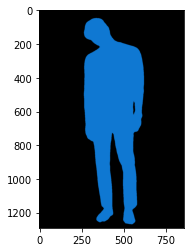

In [40]:
# 새로운 마스크 가져오기
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_mask.png'  
img_orig1 = cv2.imread(img_path1) 

print(img_orig1.shape)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

### 마스크 색상 추출 후 새로운 마스크 만들기

In [41]:
# 마스크 색상 추출
img_orig1[500:501, 600:601]

array([[[210, 120,  15]]], dtype=uint8)

(1290, 860)


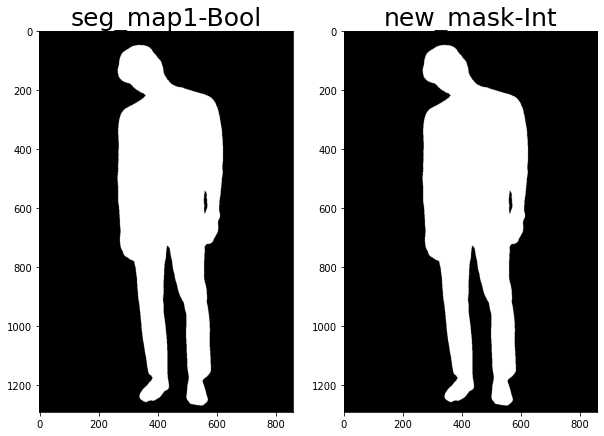

In [42]:
seg_color1 = (210,120,15)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map1 = np.all(img_orig1==seg_color1, axis=-1)
print(seg_map1.shape)

# True과 False인 값을 숫자로 바꾸기(0,255)
new_mask = seg_map1.astype(np.uint8) * 255

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(seg_map1, cmap='gray')
axs[0].set_title("seg_map1-Bool", fontsize=25)

axs[1].imshow(cv2.cvtColor(new_mask, cv2.COLOR_BGR2RGB))
axs[1].set_title("new_mask-Int", fontsize=25)

plt.show()

### 새로운 마스크로 흐린 배경 추출

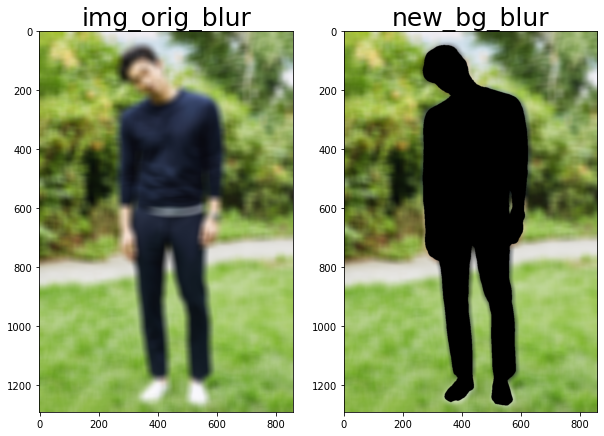

In [43]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (30,30))

# img_mask를 컬러색상으로 바꾸고 변수지정
new_mask_color = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR)
# 바꾼 컬러마스크를 색상 반전
new_bg_mask = cv2.bitwise_not(new_mask_color)
# 블러된 이미지, 컬러반전마스크를 합성해서 배경만 추출
new_bg_blur = cv2.bitwise_and(img_orig_blur, new_bg_mask)



fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
axs[0].set_title("img_orig_blur", fontsize=25)

axs[1].imshow(cv2.cvtColor(new_bg_blur, cv2.COLOR_BGR2RGB))
axs[1].set_title("new_bg_blur", fontsize=25)

plt.show()

### 이미지 합성

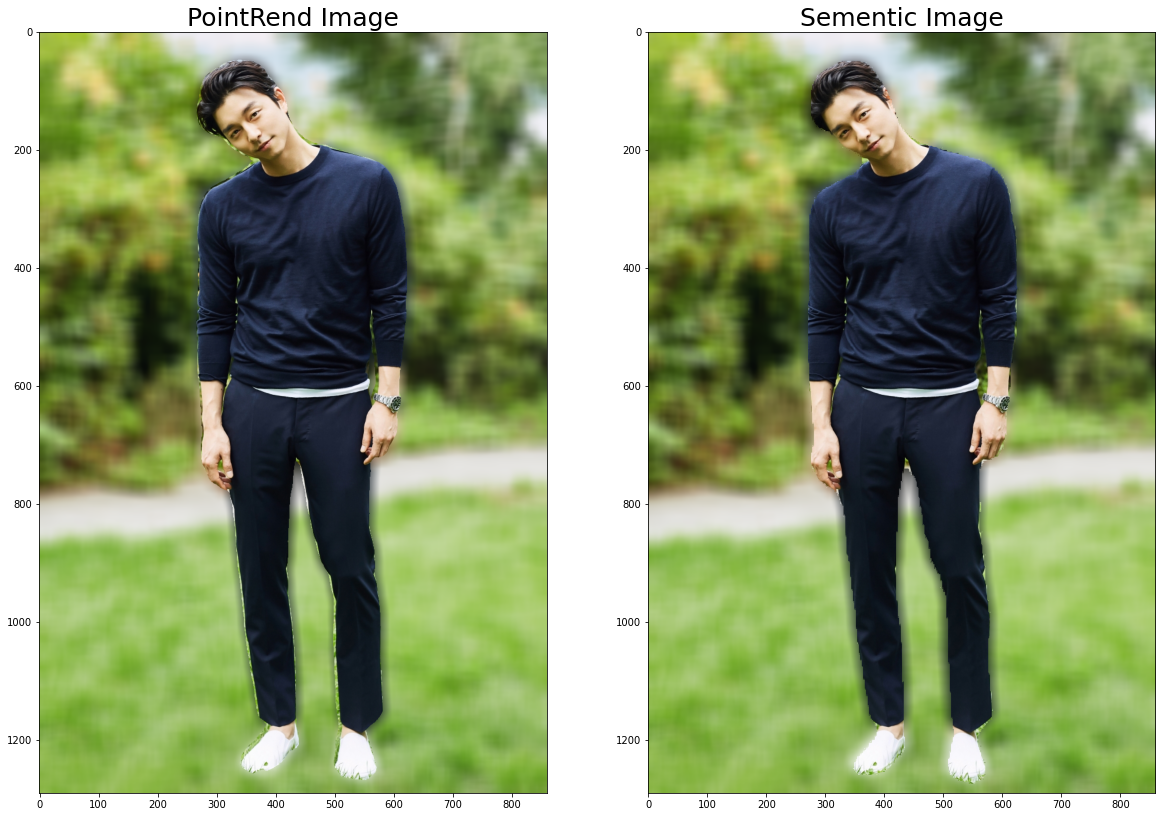

In [44]:
new_img_concat = np.where(new_mask_color==255, img_orig, new_bg_blur)
fig, axs = plt.subplots(1, 2, figsize=(20, 30))
axs[0].imshow(cv2.cvtColor(new_img_concat, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
axs[0].set_title("PointRend Image", fontsize=25)
axs[1].set_title("Sementic Image", fontsize=25)
plt.show()

# 회고

## 이번 프로젝트에서 어려웠던 점

#### Detectron 설치, 코드 이해.., 파이썬의 부족

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
### 알아낸 점
#### 세상에는 수많은 오픈소스가 존재한다.. 어떻게 활용한 것인가?? 그것은 자신의 몫인듯 하다..

### 아직 모호한 점
#### 코드, 모듈.. 역시 파이썬

## 루브릭 평가 지표를 맞츠기 위해 시도한 것들
#### Detectron, pytorch 설치, 이미지 추출하기, 수많은 구글링, YouTube....

## 자기다짐
#### 시간이 다가오니 길은 생기는 데 아직 경험 부족이라.. 삽질을 많이 해서 경험을 쌓아간다고 생각하는 데...
### 그래도 더욱 더 격렬히 쉬고 싶네요.. ㅎㅎㅎ
#### 늘 마지막은 파이썬인 것 같아요... 파이썬 공부는 언제하지?? 